### **Importing all needed libraries**

In [ ]:
# !pip install scipy
# !pip install scipy pandas


In [ ]:
#Importing all needed libraries
import pandas as pd
import numpy as np #Matric math
import tensorflow as tf #ML
from tensorflow.python.framework import ops
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import sys
import os
from scipy.io import loadmat
from scipy.io import loadmat

# sys.path.append(os.path.abspath("/Users/henda/anaconda3/Lib/site-packages"))
# from rnn_utils import *
# from public_tests import *
ops.reset_default_graph()

tf.compat.v1.reset_default_graph() #Clearning cache
sess=tf.compat.v1.InteractiveSession()




/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### **Import Training Data**

In [ ]:
def load_files():
    full_data = pd.DataFrame()
    subjects_to_load = [1]
    last_value = 0  # Initialize the last value for column 0

    for i in subjects_to_load:
        mat = loadmat(f'/content/sample_data/S{i}_E1_A1.mat')
        acc_data = mat['acc']
        glove_data = mat['glove']
        emg_data = mat['emg']
        print(acc_data.shape)
        # Combine into a DataFrame
        data = np.concatenate([acc_data,glove_data,emg_data], axis=1)
        full_data = data
    return full_data

In [ ]:
import scipy.io as sio
import pandas as pd

Data1 =load_files()
Data1.shape
Df=pd.DataFrame(Data1)
Df.head()

(1804784, 36)


,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,-0.131008,-0.773697,0.229544,-0.063546,-1.015511,-0.278134,0.189638,-0.080909,-1.090031,0.016798,...,-0.000004,3.345484e-07,0.000005,0.000010,-0.000034,0.000002,1.184058e-06,0.000004,-0.000017,-0.000025
1,-0.129806,-0.773697,0.229544,-0.063546,-1.015511,-0.278134,0.189638,-0.080909,-1.090031,0.015641,...,-0.000004,1.242333e-06,0.000004,0.000008,-0.000041,0.000003,8.203289e-07,0.000007,-0.000015,-0.000032
2,-0.129779,-0.773697,0.229544,-0.063546,-1.015511,-0.278134,0.189638,-0.080909,-1.090031,0.015616,...,-0.000002,1.006175e-06,0.000002,0.000006,-0.000035,0.000002,2.112094e-06,0.000006,-0.000013,-0.000037
3,-0.129779,-0.773697,0.229544,-0.063546,-1.015511,-0.278134,0.189638,-0.080909,-1.090031,0.015616,...,-0.000002,3.338666e-07,-0.000001,0.000002,-0.000014,0.000003,3.480324e-06,0.000003,-0.000014,-0.000037
4,-0.129779,-0.773697,0.229544,-0.063546,-1.015511,-0.278134,0.189638,-0.080909,-1.090031,0.015616,...,-0.000003,1.912998e-06,-0.000003,-0.000007,0.000005,0.000003,3.008474e-06,-0.000003,-0.000016,-0.000030


### **Data Visulaization**

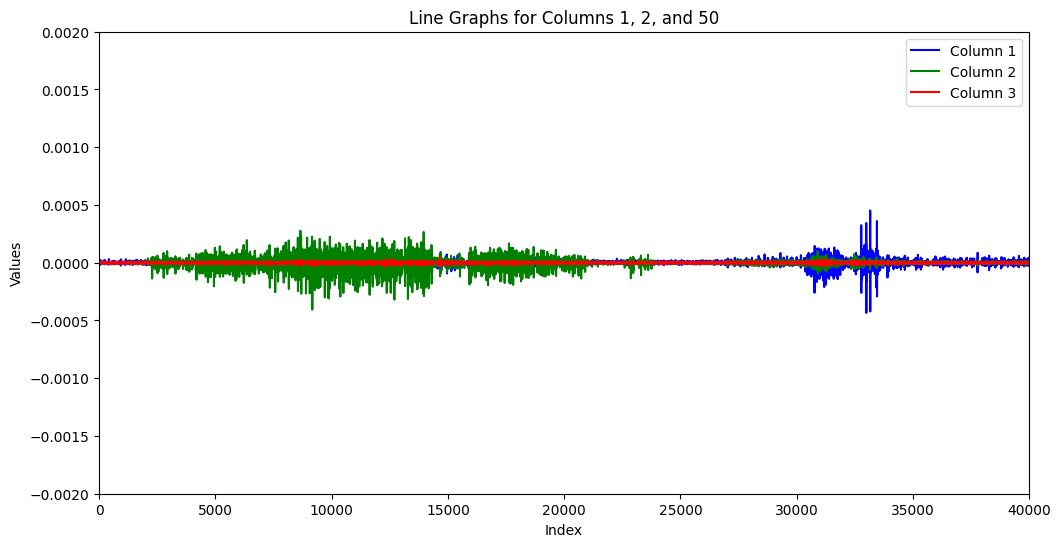

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Assuming the dataset's first column (index 0) can be used as the x-axis
# and you want to plot columns 1, 2, and 50 from your dataset
x = Df.index  # Using the DataFrame index as the x-axis
y1 = Df.iloc[:, 58]  # Column 1
y2 = Df.iloc[:, 59]  # Column 2
y3 = Df.iloc[:, 60]  # Column 50, assuming 0-based indexing

plt.figure(figsize=(12, 6))

# Plotting each column
plt.plot(x, y1, label='Column 1', color='blue')  # Line for column 1
plt.plot(x, y2, label='Column 2', color='green')  # Line for column 2
plt.plot(x, y3, label='Column 3', color='red')   # Line for column 50
plt.xlim(0, 40000)
plt.ylim(-0.002, 0.002)


plt.title('Line Graphs for Columns 1, 2, and 50')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

plt.show()


### **Apply bandpass filter**

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt

df = Df

# Define your bandpass filter parameters
fs = 1000  # Sampling frequency in Hz
lowcut = 10.0  # Low cut frequency in Hz
highcut = 100.0  # High cut frequency in Hz
order = 5  # Order of the filter

# Function to create a bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to apply a bandpass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Applying the bandpass filter to the last 12 columns
b, a = butter_bandpass(lowcut, highcut, fs, order)
for column in df.columns[-12:]:
    df[column] = butter_bandpass_filter(df[column], lowcut, highcut, fs, order)

# df now has the last 12 columns filtered with the bandpass filter


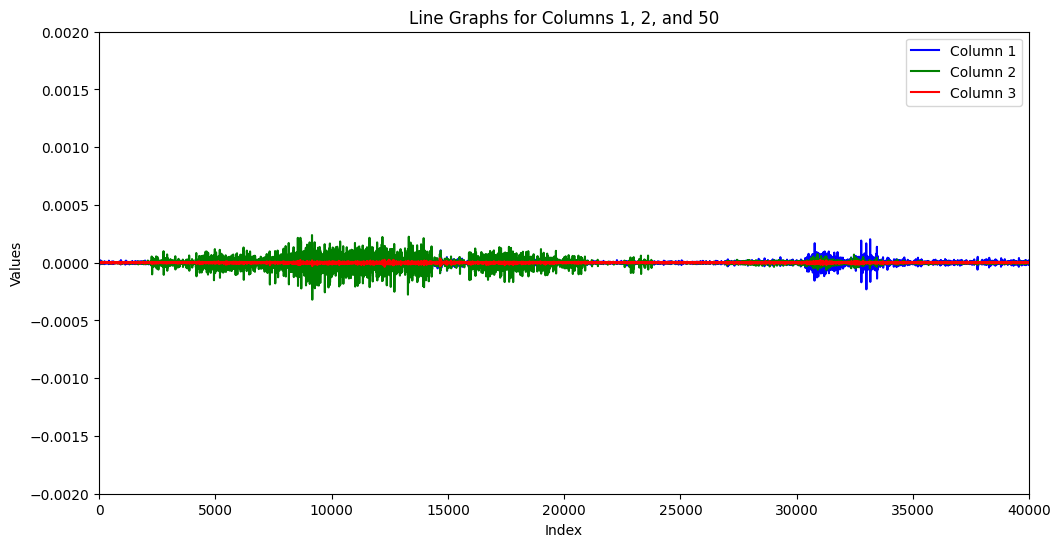

In [ ]:


# Assuming the dataset's first column (index 0) can be used as the x-axis
# and you want to plot columns 1, 2, and 50 from your dataset
x = df.index  # Using the DataFrame index as the x-axis
y1 = df.iloc[:, 58]  # Column 1
y2 = df.iloc[:, 59]  # Column 2
y3 = df.iloc[:, 60]  # Column 50, assuming 0-based indexing

plt.figure(figsize=(12, 6))

# Plotting each column
plt.plot(x, y1, label='Column 1', color='blue')  # Line for column 1
plt.plot(x, y2, label='Column 2', color='green')  # Line for column 2
plt.plot(x, y3, label='Column 3', color='red')   # Line for column 50
plt.xlim(0, 40000)
plt.ylim(-0.002, 0.002)


plt.title('Line Graphs for Columns 1, 2, and 50')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

plt.show()


### **Getting RMS of EMG signals**

In [ ]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame

# Define the window size
samples_per_window = 200  # 2000 Hz * 0.1 seconds (100 ms)

# Initialize an empty DataFrame to store RMS values
rms_df = pd.DataFrame()

# Loop through each of the first 12 columns
for column in Df.columns[-12:]:  # Adjust the range as needed
    # Initialize an empty list to store the RMS values for the current column
    column_rms = []

    # Segment the column into windows of 200 samples and calculate RMS for each segment
    for start in range(0, len(Df[column]), samples_per_window):
        window = Df[column].iloc[start:start+samples_per_window]
        rms = np.sqrt(np.mean(np.square(window)))
        column_rms.append(rms)

    # Explicitly convert the column name to string if it's not already
    rms_df[str(column) + '_RMS'] = pd.Series(column_rms)

# rms_df now contains the RMS values for each 100ms window for the first 12 columns
print(rms_df)


        58_RMS    59_RMS    60_RMS    61_RMS    62_RMS    63_RMS    64_RMS  \
0     0.000005  0.000004  0.000002  0.000003  0.000002  0.000009  0.000031   
1     0.000004  0.000002  0.000002  0.000003  0.000003  0.000006  0.000030   
2     0.000005  0.000003  0.000003  0.000003  0.000003  0.000008  0.000038   
3     0.000003  0.000003  0.000002  0.000003  0.000003  0.000008  0.000034   
4     0.000006  0.000004  0.000003  0.000003  0.000003  0.000006  0.000022   
...        ...       ...       ...       ...       ...       ...       ...   
9019  0.000016  0.000008  0.000003  0.000011  0.000003  0.000011  0.000022   
9020  0.000019  0.000010  0.000003  0.000009  0.000004  0.000011  0.000023   
9021  0.000022  0.000013  0.000003  0.000014  0.000004  0.000014  0.000023   
9022  0.000015  0.000009  0.000003  0.000009  0.000003  0.000012  0.000026   
9023  0.000024  0.000011  0.000004  0.000012  0.000004  0.000016  0.000027   

        65_RMS    66_RMS    67_RMS    68_RMS    69_RMS  
0     

### **Drawing RMS of EMG signal**

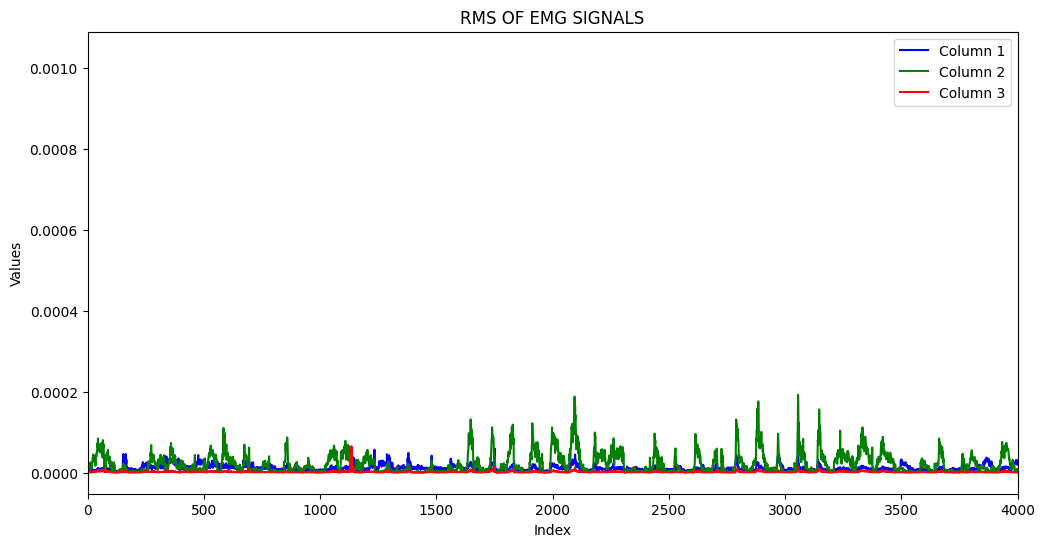

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Assuming the dataset's first column (index 0) can be used as the x-axis
# and you want to plot columns 1, 2, and 50 from your dataset
x = rms_df.index  # Using the DataFrame index as the x-axis
y1 = rms_df.iloc[:, 0]  # Column 1
y2 = rms_df.iloc[:, 1]  # Column 2
y3 = rms_df.iloc[:, 2]  # Column 50, assuming 0-based indexing

plt.figure(figsize=(12, 6))

# Plotting each column
plt.plot(x, y1, label='Column 1', color='blue')  # Line for column 1
plt.plot(x, y2, label='Column 2', color='green')  # Line for column 2
plt.plot(x, y3, label='Column 3', color='red')   # Line for column 50
plt.xlim(0, 4000)

plt.title('RMS OF EMG SIGNALS')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

plt.show()


### **Getting MAV from EMG Signal**

In [ ]:
print(df)

               0         1         2         3         4         5         6   \
0       -0.131008 -0.773697  0.229544 -0.063546 -1.015511 -0.278134  0.189638   
1       -0.129806 -0.773697  0.229544 -0.063546 -1.015511 -0.278134  0.189638   
2       -0.129779 -0.773697  0.229544 -0.063546 -1.015511 -0.278134  0.189638   
3       -0.129779 -0.773697  0.229544 -0.063546 -1.015511 -0.278134  0.189638   
4       -0.129779 -0.773697  0.229544 -0.063546 -1.015511 -0.278134  0.189638   
...           ...       ...       ...       ...       ...       ...       ...   
1804779 -0.097335 -0.789487  0.245940 -0.063546 -1.047749 -0.143032  0.173835   
1804780 -0.097335 -0.789487  0.245940 -0.063546 -1.047749 -0.141820  0.173835   
1804781 -0.097335 -0.789487  0.245940 -0.063546 -1.047749 -0.140608  0.173835   
1804782 -0.097335 -0.789487  0.245940 -0.063546 -1.047749 -0.139396  0.173835   
1804783 -0.097335 -0.789487  0.245940 -0.063546 -1.047749 -0.138184  0.173835   

               7         8 

In [ ]:


# Function to calculate Mean Absolute Value (MAV) for a data window
def calculate_mav(data):
    return np.mean(np.abs(data))

# Window size in samples
window_size = 200  # 200 samples represent 100 ms in your dataset

# Select the last 12 columns for processing
emg_columns = df.columns[-12:]

# Initialize an empty dictionary to store MAV values for each EMG channel
mav_values_dict = {column: [] for column in emg_columns}

# Calculating MAV for each of the last 12 EMG channels over 100 ms windows
for column in emg_columns:
    for start in range(0, len(df), window_size):
        end = start + window_size
        window_data = df[column][start:end]
        if len(window_data) > 0:
            mav = calculate_mav(window_data)
            mav_values_dict[column].append(mav)

# Finding the maximum number of MAV values calculated for any column to set the DataFrame length
max_length = max(len(mavs) for mavs in mav_values_dict.values())

# Creating a DataFrame from the dictionary
mav_values = pd.DataFrame(mav_values_dict, index=range(max_length))

# mav_values DataFrame contains the MAV for each window for each of the last 12 EMG channels


In [ ]:
print(mav_values)


            58        59        60        61        62        63        64  \
0     0.000003  0.000003  0.000002  0.000003  0.000002  0.000007  0.000024   
1     0.000003  0.000002  0.000001  0.000002  0.000002  0.000005  0.000019   
2     0.000004  0.000003  0.000002  0.000003  0.000002  0.000006  0.000027   
3     0.000002  0.000003  0.000002  0.000002  0.000002  0.000006  0.000022   
4     0.000004  0.000003  0.000003  0.000003  0.000002  0.000004  0.000015   
...        ...       ...       ...       ...       ...       ...       ...   
9019  0.000012  0.000006  0.000003  0.000009  0.000003  0.000008  0.000016   
9020  0.000014  0.000008  0.000002  0.000008  0.000003  0.000009  0.000017   
9021  0.000016  0.000010  0.000002  0.000012  0.000003  0.000011  0.000017   
9022  0.000011  0.000007  0.000003  0.000008  0.000002  0.000010  0.000017   
9023  0.000018  0.000007  0.000003  0.000010  0.000003  0.000012  0.000021   

            65        66        67        68        69  
0     

### **Preprocessing of kinematics , getting 100 ms average window (200 sample)**

In [ ]:
import numpy as np
import pandas as pd

# Sample DataFrame `Df` with 200 data points and 58 columns
# Df = pd.DataFrame(...)

window_size = 200  # Define the window size

# Function to downsample and calculate mean for each window
def downsample_mean(df, window_size):
    n_rows = df.shape[0]+12
    # Calculate the number of chunks
    num_chunks = np.ceil(n_rows / window_size).astype(int)
    # Preallocate a DataFrame to hold the downsampled data
    downsampled_df = pd.DataFrame(index=range(num_chunks), columns=df.columns)
    for col in df.columns[:58]:  # Assuming you want to process only columns 0 to 57
        # Process each column
        col_downsampled = []
        for i in range(num_chunks):
            start_index = i * window_size
            end_index = start_index + window_size
            # Calculate mean for the chunk
            chunk_mean = df[col][start_index:end_index].mean()
            col_downsampled.append(chunk_mean)
        downsampled_df[col] = col_downsampled
    return downsampled_df

# Apply the downsampling function to the DataFrame
Df_downsampled = downsample_mean(Df, window_size)

print(Df_downsampled)




            0         1         2         3         4         5         6   \
0    -0.131976 -0.774544  0.227107 -0.061135 -1.017465 -0.280614  0.186222   
1    -0.129779 -0.775922  0.219660 -0.056305 -1.013556 -0.279113  0.188791   
2    -0.131969 -0.775955  0.218811 -0.063546 -1.007893 -0.286572  0.185552   
3    -0.129779 -0.775840  0.218697 -0.059257 -1.012245 -0.283904  0.185191   
4    -0.129779 -0.775820  0.216457 -0.056617 -1.015511 -0.278134  0.189638   
...        ...       ...       ...       ...       ...       ...       ...   
9019 -0.064841 -0.791618  0.204517 -0.035008 -1.032719 -0.166553  0.204374   
9020 -0.060695 -0.784394  0.215361 -0.037062 -1.028610 -0.150753  0.204193   
9021 -0.049761 -0.781787  0.209829 -0.023642 -1.024856 -0.158944  0.213776   
9022 -0.056837 -0.776779  0.224723 -0.031879 -1.027864 -0.140503  0.206886   
9023 -0.072246 -0.781286  0.234463 -0.045432 -1.039378 -0.137989  0.199433   

            7         8         9   ...   60   61   62   63   6

In [ ]:
# If you need to update the original DataFrame with the averaged columns:
dd=Df_downsampled.iloc[:,:58]
data=pd.concat([dd,rms_df, mav_values], axis=1)
print(data)

            0         1         2         3         4         5         6   \
0    -0.131976 -0.774544  0.227107 -0.061135 -1.017465 -0.280614  0.186222   
1    -0.129779 -0.775922  0.219660 -0.056305 -1.013556 -0.279113  0.188791   
2    -0.131969 -0.775955  0.218811 -0.063546 -1.007893 -0.286572  0.185552   
3    -0.129779 -0.775840  0.218697 -0.059257 -1.012245 -0.283904  0.185191   
4    -0.129779 -0.775820  0.216457 -0.056617 -1.015511 -0.278134  0.189638   
...        ...       ...       ...       ...       ...       ...       ...   
9019 -0.064841 -0.791618  0.204517 -0.035008 -1.032719 -0.166553  0.204374   
9020 -0.060695 -0.784394  0.215361 -0.037062 -1.028610 -0.150753  0.204193   
9021 -0.049761 -0.781787  0.209829 -0.023642 -1.024856 -0.158944  0.213776   
9022 -0.056837 -0.776779  0.224723 -0.031879 -1.027864 -0.140503  0.206886   
9023 -0.072246 -0.781286  0.234463 -0.045432 -1.039378 -0.137989  0.199433   

            7         8         9   ...        60        61    

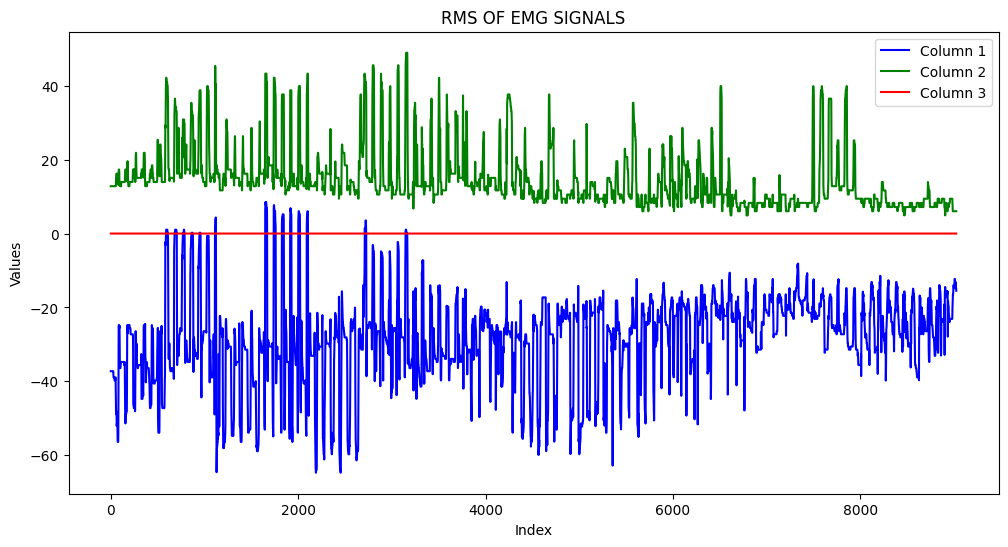

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Assuming the dataset's first column (index 0) can be used as the x-axis
# and you want to plot columns 1, 2, and 50 from your dataset
x = data.index  # Using the DataFrame index as the x-axis
y1 = data.iloc[:, 37]  # Column 1
y2 = data.iloc[:, 38]  # Column 2
y3 = data.iloc[:, 69]  # Column 50, assuming 0-based indexing

plt.figure(figsize=(12, 6))

# Plotting each column
plt.plot(x, y1, label='Column 1', color='blue')  # Line for column 1
plt.plot(x, y2, label='Column 2', color='green')  # Line for column 2
plt.plot(x, y3, label='Column 3', color='red')   # Line for column 50

plt.title('RMS OF EMG SIGNALS')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

plt.show()


### **Save the preprocessed Data**

In [ ]:
from numpy import asarray
from numpy import savetxt
# define data
# save to csv file
savetxt('sample_data/S45_E1.csv', data, delimiter=',')
